In [1]:
# General imports
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import collections
import os
from time import time

# Data Science
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

# Algorithms / estimators
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Process
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

# Corpus
from documentModel import DocumentModel as DM
from export_results import *

from scipy import stats

def is_significant(model_1, model_2, significance = 0.05):
    
    p_value = stats.wilcoxon(recall_avg[model_1], recall_avg[model_2])[1]
    print(p_value)
    if p_value < significance:
        print("It is statically significant")
    else:    
        print("It is NOT statically significant")

# Business Rule Classification

In [2]:
stop_words = ['a', 'bajo', 'en', 'para','un', 'la', 'el', 'los', 'las', 'su', 'sus', 'través', 'al','con', \
             'más', 'muy', 'cual', 'poco', 'que']

print("Transforming annotated files into training datasets...")
dm = DM()
fito_dataset = dm.get_sentences(0)
X, y = fito_dataset["data"], fito_dataset["target"]

print("OK")

Transforming annotated files into training datasets...
Processing 11120
Processing 11178
Processing 11179
Processing 11231
Processing 11314
Processing 11318
Processing 11350
Processing 11355
Processing 11372
Processing 11388
Processing 11391
Processing 11412
Processing 11420
Processing 11469
Processing 11485
Processing 11530
Processing 11533
Processing 11551
Processing 11557
Processing 11565
Processing 11571
Processing 11572
Processing 11582
Processing 11608
Processing 11725
Processing 11736
Processing 11744
Processing 11759
Processing 11760
Processing 11777
Processing 11780
Processing 11797
Processing 11807
Processing 11811
Processing 11821
Processing 11826
Processing 11830
Processing 11837
Processing 11909
Processing 11930
Processing 11952
Processing 12031
Processing 12033
Processing 12054
Processing 12070
Processing 12071
Processing 12072
Processing 12162
Processing 12163
Processing 12180
Processing 12211
Processing 12240
Processing 12272
Processing 12276
Processing 12281
Processing

In [3]:
# like the ShuffleSplit strategy, stratified random splits do not guarantee 
#that all folds will be different, although this is still very likely for sizeable datasets
sss = StratifiedShuffleSplit(y, n_iter = 10, test_size=0.2, random_state=0)
extractor = TfidfVectorizer(use_idf=True, stop_words=stop_words)
models = [("Decision Tree", DecisionTreeClassifier), 
          ("Random Forest", RandomForestClassifier),
          ("Naive Bayes", MultinomialNB),
          ("Linear SVC", SVC),
          ("Always Positive", DummyClassifier)]

costs = range(2,30)
axis_costs = range(1,19)

recall_avg = {}
recall_avg["Decision Tree"] = []
recall_avg["Random Forest"] = []
recall_avg["Naive Bayes"] = []
recall_avg["Linear SVC"] = []
recall_avg["Always Positive"] = []

recall_std = {}
recall_std["Decision Tree"] = []
recall_std["Random Forest"] = []
recall_std["Naive Bayes"] = []
recall_std["Linear SVC"] = []
recall_std["Always Positive"] = []


precision_avg = {}
precision_avg["Decision Tree"] = []
precision_avg["Random Forest"] = []
precision_avg["Naive Bayes"] = []
precision_avg["Linear SVC"] = []
precision_avg["Always Positive"] = []

precision_std = {}
precision_std["Decision Tree"] = []
precision_std["Random Forest"] = []
precision_std["Naive Bayes"] = []
precision_std["Linear SVC"] = []
precision_std["Always Positive"] = []


for estimator in models:
    for cost in costs:
        if estimator[0] == "Naive Bayes":
            model = estimator[1](class_prior=[1/cost, (cost-1)/cost], fit_prior= False)
        elif estimator[0] == "Random Forest":
            model = estimator[1](class_weight={1:cost-1}, n_estimators = 20)
        elif estimator[0] == "Linear SVC":
            model = estimator[1](class_weight={1:cost-1}, kernel = "linear")
        elif estimator[0] == "Always Positive":
            model = estimator[1](strategy = "constant", random_state = 2016, constant=1)
        else:
            model = estimator[1](class_weight={1:cost-1})
        extractor.fit(X)
        false_positives = []
        false_negatives = []
        true_positives = []
        precisions = []
        recalls = []
        for train_index, test_index in sss:
            X_train, X_test = extractor.transform(X)[train_index], extractor.transform(X)[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            #cm = confusion_matrix(y_test, model.predict(X_test))
            #false_negatives.append(cm[1][0]/collections.Counter(y_test)[1])
            precisions.append(precision_score(y_test, model.predict(X_test), pos_label=1))
            recalls.append(recall_score(y_test, model.predict(X_test), pos_label=1))
        recall_avg[estimator[0]].append(np.average(recalls))
        recall_std[estimator[0]].append(np.std(recalls))
        precision_avg[estimator[0]].append(np.average(precisions))
        precision_std[estimator[0]].append(np.std(precisions))

In [7]:
sss = StratifiedShuffleSplit(y, n_iter = 10, test_size=0.2, random_state=0)

In [9]:
sss.n_test

103

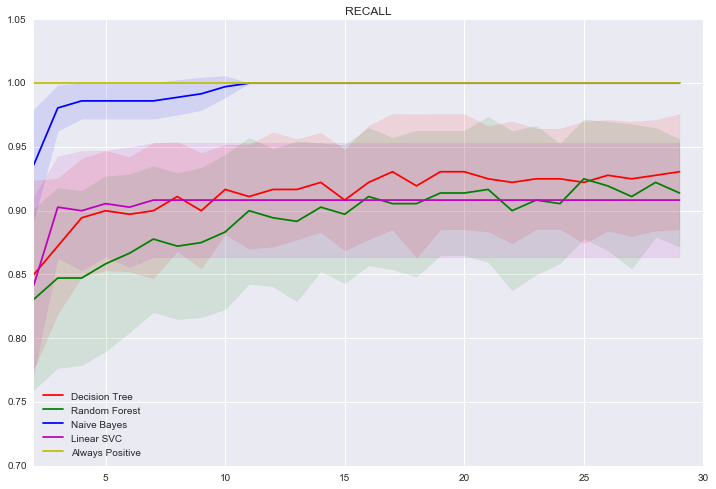

In [4]:
colors = "rgbmy"
plt.figure(figsize=(12,8))
plt.ylim([0.7, 1.05])
plt.xlim([2, 30])
plt.title("RECALL")
for model, color in zip(models, colors):
    plt.plot(costs, recall_avg[model[0]], color=color, label=model[0])
    plt.fill_between(costs, np.asarray(recall_avg[model[0]]) - recall_std[model[0]], 
                 np.asarray(recall_avg[model[0]]) + recall_std[model[0]], 
                 alpha=0.1, color=color)

plt.legend(loc='better')
plt.show()

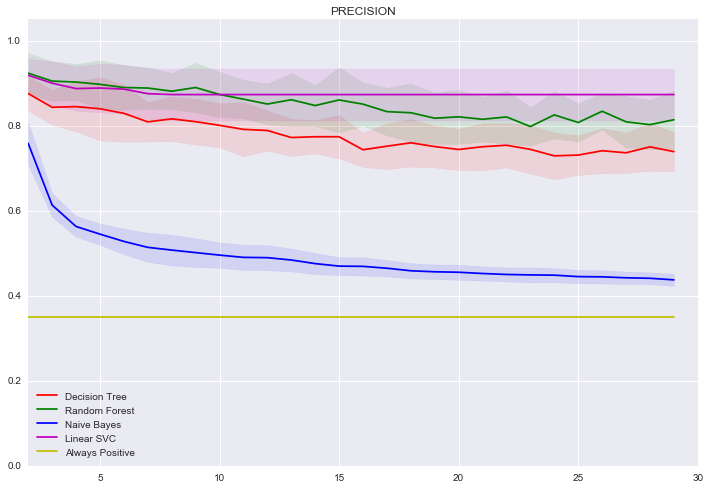

In [5]:
colors = "rgbmy"
plt.figure(figsize=(12,8))
plt.ylim([0.0, 1.05])
plt.xlim([2, 30])
plt.title("PRECISION")
for model, color in zip(models, colors):
    plt.plot(costs, precision_avg[model[0]], color=color, label=model[0])
    plt.fill_between(costs, np.asarray(precision_avg[model[0]]) - precision_std[model[0]], 
                 np.asarray(precision_avg[model[0]]) + precision_std[model[0]], 
                 alpha=0.1, color=color)

plt.legend(loc='better')
plt.show()

In [50]:
is_significant("Decision Tree", "Linear SVC", significance = 0.05)
print("")
is_significant("Random Forest", "Decision Tree", significance = 0.05)
print("")
is_significant("Random Forest", "Linear SVC", significance = 0.05)

0.00529276682317
It is statically significant

3.74060333567e-06
It is statically significant

0.00245269291459
It is statically significant


In [18]:
for model in models:
    print(model[0])
    print(recall_avg[model[0]])
    print()

Decision Tree
[0.8472222222222221, 0.86944444444444446, 0.875, 0.90277777777777768, 0.89166666666666661, 0.89166666666666661, 0.91111111111111109, 0.90555555555555556, 0.91666666666666663, 0.91111111111111109, 0.91111111111111109, 0.91944444444444451, 0.92222222222222217, 0.91944444444444451, 0.92222222222222217, 0.92500000000000004, 0.9277777777777777, 0.92222222222222217, 0.92777777777777781, 0.92222222222222217, 0.92500000000000004, 0.92777777777777781, 0.92500000000000004, 0.92222222222222228, 0.93055555555555558, 0.91666666666666663, 0.92500000000000004, 0.93055555555555558]

Random Forest
[0.83888888888888891, 0.84444444444444444, 0.85277777777777763, 0.86666666666666681, 0.85555555555555551, 0.87222222222222212, 0.85555555555555551, 0.89444444444444449, 0.88611111111111107, 0.88888888888888873, 0.8999999999999998, 0.91111111111111109, 0.90833333333333321, 0.91111111111111109, 0.8999999999999998, 0.90833333333333321, 0.9027777777777779, 0.91111111111111109, 0.90555555555555556, 0

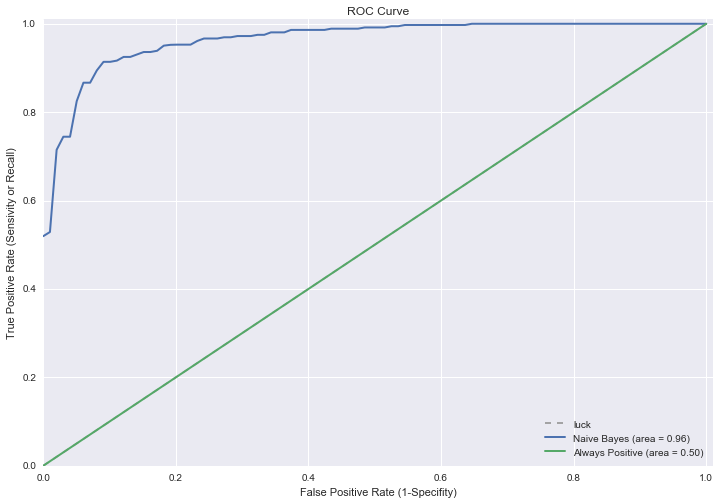

In [20]:
# Classification and ROC analysis
sss = StratifiedShuffleSplit(y, n_iter = 10, test_size=0.2, random_state=0)

X, y = fito_dataset["data"], fito_dataset["target"]
X_trans = extractor.transform(X)

models = [("Naive Bayes", MultinomialNB(class_prior=[0.01, 0.99])),
         ("Always Positive", DummyClassifier(strategy='constant', constant=1))]

plt.figure(figsize=(12,8))
plt.plot([0,1], [0,1], '--', color=(0.6,0.6,0.6), label='luck')

for model in models:
    mean_tpr = 0.0
    mean_fpr = np.linspace(0,1,100)
    for i, (train, test) in enumerate(sss):
        probas_ = model[1].fit(X_trans[train], y[train]).predict_proba(X_trans[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1], pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        roc_auc = auc(fpr, tpr)
        #plt.plot(fpr, tpr, lw =1, label = 'ROC fold %d (area = %0.2f)' % (i, roc_auc))
    mean_tpr /= len(sss)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, label='%s (area = %0.2f)' % (model[0], mean_auc), lw = 2)
        
plt.ylim([0.0, 1.01])
plt.xlim([0.0, 1.01])
plt.xlabel('False Positive Rate (1-Specifity)')
plt.ylabel('True Positive Rate (Sensivity or Recall)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# NER

In [2]:
import xml.etree.ElementTree as ET
import pymysql.cursors

In [3]:
thesauro = []

# Connect to the database
connection = pymysql.connect(host='localhost',
                             user='root',
                             password='',
                             db='fitosanitarios',
                             charset='utf8')

try:
    with connection.cursor() as cursor:
        sql = "SELECT * FROM cultivosenfitosanitarios"
        cursor.execute(sql)
        results = cursor.fetchall()
        
        for row in results:
            thesauro.append((row[0],row[1]))
finally:
    connection.close()

In [4]:
import xml.etree.ElementTree as ET
import codecs

forbidden_tagged_sentences = []

tree = ET.parse('/Users/b3j90/Downloads/MAE_v0.9.6/annotations/generales.xml')
root = tree.getroot()

obligations = root.findall('./TAGS/prohibition')
for obligation in obligations:
    forbidden_tagged_sentences.append((\
            obligation.attrib["idcorpus"],obligation.attrib["text"]))#, cultivo.attrib["newReference"]))
    

cultivosAnotados = []

tree = ET.parse('/Users/b3j90/Downloads/MAE_v0.9.6/annotations/generales.xml')
root = tree.getroot()

cultivos = root.findall('./TAGS/cultivo')
for cultivo in cultivos:
    if cultivo.attrib["newReference"] == "no" and not cultivo.attrib["text"] == 'fruta':
        cultivosAnotados.append((cultivo.attrib["idthesaurus"], \
                                 cultivo.attrib["idcorpus"],cultivo.attrib["text"]))#, cultivo.attrib["newReference"]))

In [5]:
def divide(sentence, n):
    ngrams = []
    lWords = sentence.replace(',','').replace(')','').replace("'",'').split(' ')
    i = 0
    while i < len(lWords)- (n-1):
        j = 0
        word = ''
        while j < n:
            word = word + lWords[i+j] + ' '
            j = j +1
        i = i+1
        #print word
        ngrams.append(word)
    return ngrams

def compare(s1):
    stopwords = ['de', 'la', 'el', 'las', 'los', 'del']
    for t in thesauro:
        if len(s1) > 2:
            if s1.strip().lower() == t[1].lower() \
            or s1.strip().lower()[:-1] == t[1].lower() \
            or s1.strip().lower()[:-2] == t[1].lower() \
            or s1.strip().lower() == t[1].lower()[:-1] \
            or s1.strip().lower() == t[1].lower()[:-2]: # playing with plurals
            
                return t[0] # Identifier

def evaluate(ner):
    for gold in cultivosAnotados:
        if gold[:-1] == ner[:-1]:
            return True

In [17]:
# Accuracy: 0.846 in 13.75 minutes
tp = 0
fp = 0
truePositives = []
completed = []

t0 = time()
for cond in forbidden_tagged_sentences:
    grams = divide(cond[1],1)
    if grams is not None:
        for g in grams:
            res = compare(g)
            if res is not None:
                ner = ( str(res),cond[0], g)
                if (evaluate(ner)):
                    if (str(res), cond[0]) not in completed:
                        truePositives.append((g, cond[0]))
                        completed.append((str(res), cond[0]))
                        tp += 1
                else:
                    if not str(res).startswith('3'):
                        fp += 1
            else:
                

t1 = time()
print("Accuracy: %.3f in %.2f minutes" % (tp * 1.0 /(len(cultivosAnotados)), (t1-t0) / 60))
print("Precision: %.3f" % (tp * 1.0 /(tp + fp)))
print("Recall: %.3f" % (tp * 1.0 /(tp + len(cultivosAnotados))))

Accuracy: 0.436 in 0.12 minutes
Precision: 0.436
Recall: 0.304


In [18]:
print(cultivosAnotados[:5])

[('103010101010000', '2953', 'maíz'), ('103010101010100', '2953', 'maíz dulce'), ('103020300000000', '2953', 'patata'), ('104010102000000', '2953', 'zanahoria'), ('104010702000000', '2953', 'guisantes')]


In [19]:
print(forbidden_tagged_sentences[:5])

[('3862', 'A efectos de prevenir la aparición de resistencias, no aplicar con este producto ni con ningún otro perteneciente a la familia de las oxadiazinas mas de tres tratamientos por ciclo de cultivo, espaciados 10-14 días'), ('2747', 'A efectos de prevenir la aparición de resistencias, no efectuar con este producto ni con ningún otro con el mismo tipo de acción más de los tratamientos por ciclo de cultivo, que se indican en cada caso'), ('1086', 'No aplicar aceites minerales durante 21 días anteriores o posteriores a la aplicación del azufre'), ('30', 'No aplicar aceites minerales durante los 21 anteriores o posteriores a la aplicación del azufre'), ('6', 'No aplicar aceites minerales durante los 21 días anteriores o posteriores a la aplicación del azufre')]


In [3]:
X

['Aplicar sobre el suelo en pequeños montones o cordones entre las líneas de siembra en los puntos a proteger, siendo conveniente que el suelo esté húmedo para mayor actividad de estos parásitos',
 'Evitar que el producto caiga sobre las plantas cualtivadas',
 'Advertir en la etiqueta que es peligroso para perros y otros animales domésticos',
 'Aplicar en pulverización normal, variando la dosis según temperatura ambiental, cultivo, época de tratamiento, etc',
 'En la etiqueta deberán figurar las instrucciones de uso del producto en cultivos sensibles',
 'No mezclar con aceites ni productos de reacción alcalina, ni efectuar tratamientos a temperaturas demasiado elevadas',
 'No aplicar aceites minerales durante los 21 días anteriores o posteriores a la aplicación del azufre',
 'No aplicar en cultivos cuyos frutos sean destinados a conserva',
 'No aplicar en alcachofa ni en algunas variedades de frutales sensibles como albaricoquero, manzano y peral',
 'Aplicar en pulverización normal, de